In [ ]:
import json
import requests
from pprint import pprint
import re
import string
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import warnings
import sys
import torch

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cpu':
  raise RuntimeError('No GPU found')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# Đặt random seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Tiền xử lí dữ liệu

## Load dataset


In [ ]:
# news_dataset_path = '/content/drive/MyDrive/AI4E/Project_ML NLP/data/news_final.json'
# news_dataset_path = '/content/drive/MyDrive/Colab Notebooks/news_dataset.json'
news_dataset_path = '/content/drive/MyDrive/Classroom/news_dataset.json'

with open(news_dataset_path, 'r', encoding='utf-8') as fIn:
    data = json.load(fIn)
data[1], len(data)

({'url': 'https://vietnamnet.vn/doanh-nghiep-trong-nganh-co-khi-tu-dong-hoa-dung-truoc-nhieu-co-hoi-moi-2069357.html',
  'title': 'Doanh nghiệp trong ngành cơ khí tự động hóa đứng trước nhiều cơ hội mới',
  'description': 'Triển lãm và hội thảo quốc tế lần thứ 8 về máy công cụ, cơ khí chính xác và gia công kim loại - MTA Hanoi 2022 quy tụ hàng trăm DN trong và ngoài nước tham gia. Đây là cơ hội tốt để các DN Việt Nam tiếp cận với công nghệ và cơ hội hợp tác mới.',
  'content': 'Nhiều công nghệ và giải pháp mới được giới thiệu\nMTA Hanoi 2022 có sự tham gia của các doanh nghiệp đến từ hơn 18 quốc gia, vùng lãnh thổ đến từ các quốc gia phát triển như: Đức, Anh, Áo, Thổ Nhĩ Kỳ, Nhật Bản, Trung Quốc, Đài Loan, Hàn Quốc, Singapore, Israel, Malaysia, Thái Lan, Việt Nam và gần 100 gian hàng với tổng diện tích trưng bày trên 5000 m2.\nNăm nay, MTA Hanoi 2022 giới thiệu đến cộng đồng sản xuất - chế tạo hàng loạt các công nghệ và giải pháp tiên tiến. Bên cạnh đó, triển lãm sẽ tiếp tục mang đến c

In [ ]:
# Lọc ra số lượng bài báo mỗi danh mục
categories = [article['metadata']['cat'] for article in data]
category_counts = {}
for category in categories:
  if category in category_counts:
    category_counts[category] += 1
  else:
    category_counts[category] = 1
for category, count in category_counts.items():
  print(f'{category}: {count}')

DÂN TỘC THIỂU SỐ VÀ MIỀN NÚI: 388
CÔNG NGHIỆP HỖ TRỢ: 261
TÌNH YÊU - GIỚI TÍNH: 408
Giáo dục: 366
ĐỜI SỐNG: 684
BẤT ĐỘNG SẢN: 766
SÁCH: 329
Thời sự: 404
THẾ GIỚI: 797
Thế giới: 417
SỨC KHỎE: 801
KINH DOANH: 995
CHÍNH TRỊ: 372
Số hóa: 390
KHOA HỌC - CÔNG NGHỆ: 345
XÃ HỘI: 374
DU LỊCH: 776
Pháp luật: 420
GIÁO DỤC: 673
Du lịch: 398
PHÁP LUẬT: 775
Ô TÔ - XE MÁY: 652
VĂN HÓA: 666
TUẦN VIỆT NAM: 394
Thể thao: 326
THỂ THAO: 706
LAO ĐỘNG - VIỆC LÀM: 386
Kinh doanh: 404
DÂN TỘC - TÔN GIÁO: 322
Giải trí: 401
NỘI DUNG CHUYÊN ĐỀ: 406
GIẢI TRÍ: 708
BẠN ĐỌC: 382
THỊ TRƯỜNG - TIÊU DÙNG: 140
THÔNG TIN VÀ TRUYỀN THÔNG: 396
Xe: 317
Bất động sản: 418
NÔNG THÔN MỚI: 417
Sức khỏe: 198
Khoa học: 368
AN SINH: 360
Đời sống: 340
SỨC MẠNH SỐ: 197
BẢO VỆ NGƯỜI TIÊU DÙNG: 96
: 74
Các bệnh: 175
NHỊP SỐNG TRẺ: 33
NET ZERO: 23
THỜI SỰ: 40
Trang chủ: 22
ẢNH: 14
NHIỆM VỤ: 1
TẾT 2024: 1


Filtered articles count: 15876


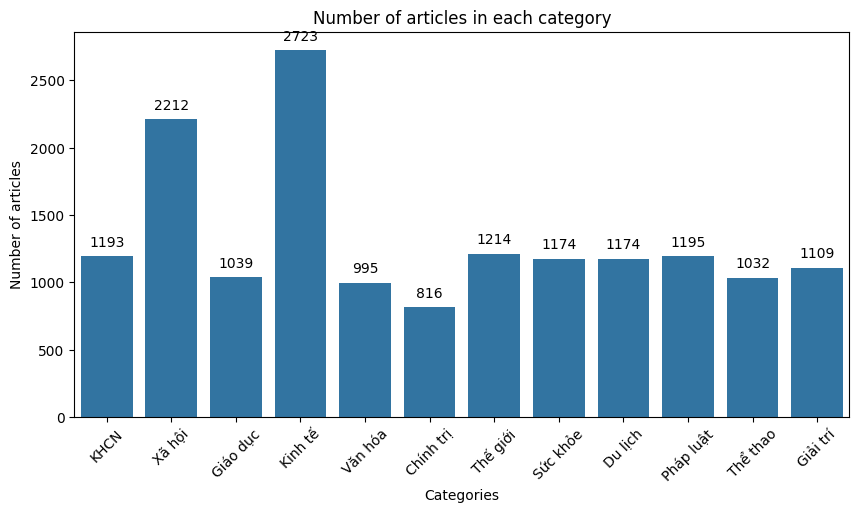

In [ ]:
# Từ điển ánh xạ các categories hiện tại về 12 loại
category_mapping = {
    "CHÍNH TRỊ": "Chính trị",
    "THỜI SỰ": "Chính trị",
    "Thời sự": "Chính trị",
    "XÃ HỘI": "Xã hội",
    "ĐỜI SỐNG": "Xã hội",
    "AN SINH": "Xã hội",
    "LAO ĐỘNG - VIỆC LÀM": "Xã hội",
    "TÌNH YÊU - GIỚI TÍNH": "Xã hội",
    "KHOA HỌC - CÔNG NGHỆ": "KHCN",
    "SỨC MẠNH SỐ": "KHCN",
    "Số hóa": "KHCN",
    "CÔNG NGHIỆP HỖ TRỢ": "KHCN",
    "KINH DOANH": "Kinh tế",
    "Kinh doanh": "Kinh tế",
    "THỊ TRƯỜNG - TIÊU DÙNG": "Kinh tế",
    "BẤT ĐỘNG SẢN": "Kinh tế",
    "Bất động sản": "Kinh tế",
    "THẾ GIỚI": "Thế giới",
    "Thế giới": "Thế giới",
    "VĂN HÓA": "Văn hóa",
    "SÁCH": "Văn hóa",
    "GIẢI TRÍ": "Giải trí",
    "Giải trí": "Giải trí",
    "DU LỊCH": "Du lịch",
    "Du lịch": "Du lịch",
    "GIÁO DỤC": "Giáo dục",
    "Giáo dục": "Giáo dục",
    "SỨC KHỎE": "Sức khỏe",
    "Sức khỏe": "Sức khỏe",
    "Các bệnh": "Sức khỏe",
    "PHÁP LUẬT": "Pháp luật",
    "Pháp luật": "Pháp luật",
    "THỂ THAO": "Thể thao",
    "Thể thao": "Thể thao"
}
import copy
# Tạo một bản sao sâu của danh sách
copy_data = copy.deepcopy(data)
#Lọc và chuyển data
filtered_data = []
for article in copy_data:
  if article['metadata']['cat'] in category_mapping:
    article['metadata']['cat'] = category_mapping[article['metadata']['cat']]
    filtered_data.append(article)
# Số lượng bài báo sau khi lọc
print(f'Filtered articles count: {len(filtered_data)}')

#Trích xuất danh mục
categories = [article['metadata']['cat'] for article in filtered_data]
category_counts = {}
for category in categories:
  if category in category_counts:
    category_counts[category] += 1
  else:
    category_counts[category] = 1

#Vẽ biểu đồ
plt.figure(figsize = (10, 5))
ax = sns.barplot(x = list(category_counts.keys()), y = list(category_counts.values()))
plt.xlabel('Categories')
plt.ylabel('Number of articles')
plt.title('Number of articles in each category')
plt.xticks(rotation = 45)
# Thêm số lượng ở trên mỗi cột
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

Filtered articles to use count: 9792


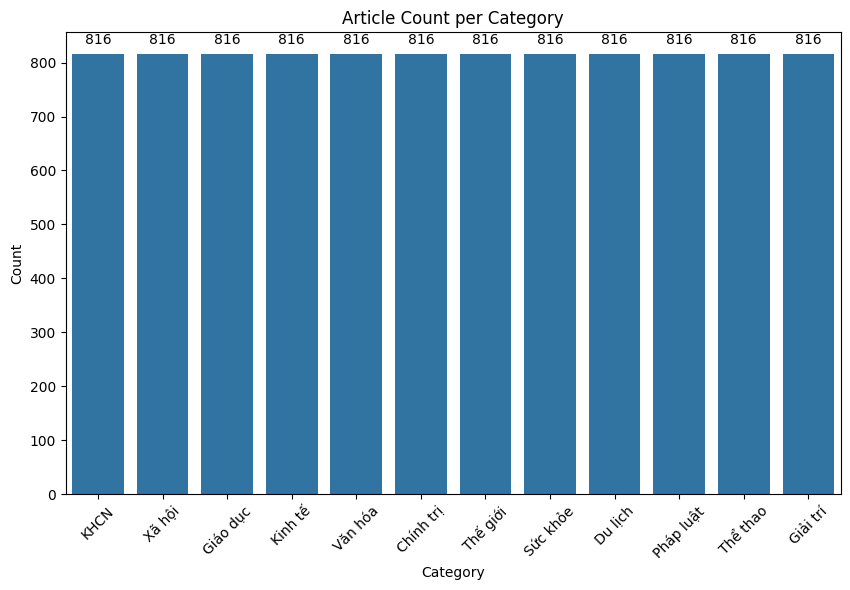

In [ ]:
category_data = defaultdict(list)
for article in filtered_data:
  category = article['metadata']['cat']
  category_data[category].append(article)

number_sample = 9792
max_samples_per_category = number_sample // len(category_data)

filtered_data_to_use = []
for category, items in category_data.items():
      filtered_data_to_use.extend(random.sample(items, max_samples_per_category))
print(f"Filtered articles to use count: {len(filtered_data_to_use)}")

# Đếm số lượng từng danh mục
category_counts = defaultdict(int)
for item in filtered_data_to_use:
    category_counts[item['metadata']['cat']] += 1

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()))
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Article Count per Category')
plt.xticks(rotation=45)

# Thêm số lượng ở trên mỗi cột
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [ ]:
#Trích xuất text và label
texts = []
labels = []
for article in filtered_data_to_use:
  # Tiêu đề + nội dung
  text = article.get('title', '') + ' ' + article.get('content')
  # Category của bài báo
  label = article['metadata']['cat']
  texts.append(text)
  labels.append(label)

## Làm sạch dữ liệu

In [ ]:
# Stopwords tiếng việt
stop_words = set([
    "bị", "bởi", "cả", "các", "cái", "cần", "càng", "chỉ", "chiếc", "cho", "chứ", "chưa", "chuyện",
    "có", "có_thể", "cứ", "của", "cùng", "cũng", "đã", "đang", "đây", "để", "đến_nỗi", "đều", "điều",
    "do", "đó", "được", "dưới", "gì", "khi", "không", "là", "lại", "lên", "lúc", "mà", "mỗi", "này",
    "nên", "nếu", "ngay", "nhiều", "như", "nhưng", "những", "nơi", "nữa", "phải", "qua", "ra", "rằng",
    "rằng", "rất", "rồi", "sau", "sẽ", "so", "sự", "tại", "theo", "thì", "trên", "trước", "từ", "từng",
    "và", "vẫn", "vào", "vậy", "vì", "việc", "với", "vừa"
])

def preprocess(text):
  # Chuyển thành chữ thường
  text = text.lower()
  # Loại bỏ dấu câu
  text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
  # Loại bỏ khoảng trắng thừa
  text = re.sub(r'\s+', ' ', text).strip()
  # Tách văn bản thành các từ (tokens)
  tokens = text.split()
  #  Đếm tổng số từ ban đầu
  total_tokens = len(tokens)
  # Loại bỏ các từ thuộc danh sách stop words
  tokens = [token for token in tokens if token not in stop_words]
  # Tính phần trăm các từ stop words đã bị loại bỏ
  removed_stop_words_percent = (total_tokens - len(tokens)) / total_tokens * 100
  # Trả về văn bản đã được xử lý và phần trăm từ stop words đã bị loại bỏ
  return ' '.join(tokens), removed_stop_words_percent

In [ ]:
def preprocessing_text(texts):
  preprocessed_texts = []
  sum_stop_words_percent = 0
  tqdm_iter = tqdm(texts, desc = "Preprocessing texts")

  for i, text in enumerate(tqdm_iter):
    # Tiền xử lí văn bản
    preprocessed_text, stop_words_percent = preprocess(text)
    preprocessed_texts.append(preprocessed_text)
    sum_stop_words_percent += stop_words_percent
  average_stop_words_percent = sum_stop_words_percent / len(texts)
  # In ra phần trăm trung bình của các từ stop words đã bị loại bỏ
  print(f"Average percentage of stop words removed: {average_stop_words_percent:.2f}%")
  return preprocessed_texts

In [ ]:
texts = preprocessing_text(texts)

Preprocessing texts:   0%|          | 0/9792 [00:00<?, ?it/s]

Average percentage of stop words removed: 18.59%


In [ ]:
y = np.array(labels)
texts_train, texts_test, y_train, y_test = train_test_split(texts, y, test_size = 0.2, stratify = y, random_state = 42)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)
texts_train, y_train_enc = shuffle(texts_train, y_train_enc, random_state=42)

# Huấn luyện các mô hình truyền thống

## Vectorize texts

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None)
X_train_tfidf = tfidf_vectorizer.fit_transform(texts_train)
X_test_tfidf = tfidf_vectorizer.transform(texts_test)

## Mô hình Naive Bayes

In [ ]:
nb_model = MultinomialNB(alpha=1.0)

nb_model.fit(X_train_tfidf, y_train_enc)

nb_y_pred_enc = nb_model.predict(X_test_tfidf)
nb_y_pred = le.inverse_transform(nb_y_pred_enc)

nb_report = classification_report(y_test, nb_y_pred, output_dict=True, zero_division=0)


## Mô hình SVM

In [ ]:
svm_model = SVC(kernel='linear', C=1)

svm_model.fit(X_train_tfidf, y_train_enc)

svm_y_pred_enc = svm_model.predict(X_test_tfidf)
svm_y_pred = le.inverse_transform(svm_y_pred_enc)

svm_report = classification_report(y_test, svm_y_pred, output_dict=True, zero_division=0)

## Vẽ biểu đồ


Naive Bayes Metrics:
Chính trị: Precision=0.43, Recall=0.54, F1-Score=0.48
Du lịch: Precision=0.71, Recall=0.56, F1-Score=0.63
Giáo dục: Precision=0.92, Recall=0.65, F1-Score=0.76
Giải trí: Precision=0.63, Recall=0.45, F1-Score=0.52
KHCN: Precision=0.44, Recall=0.50, F1-Score=0.47
Kinh tế: Precision=0.54, Recall=0.40, F1-Score=0.46
Pháp luật: Precision=0.65, Recall=0.71, F1-Score=0.68
Sức khỏe: Precision=0.74, Recall=0.77, F1-Score=0.76
Thế giới: Precision=0.70, Recall=0.70, F1-Score=0.70
Thể thao: Precision=0.61, Recall=0.74, F1-Score=0.67
Văn hóa: Precision=0.50, Recall=0.53, F1-Score=0.51
Xã hội: Precision=0.39, Recall=0.50, F1-Score=0.44
Overall Accuracy: 0.59

SVC Metrics:
Chính trị: Precision=0.42, Recall=0.58, F1-Score=0.48
Du lịch: Precision=0.55, Recall=0.63, F1-Score=0.58
Giáo dục: Precision=0.96, Recall=0.64, F1-Score=0.77
Giải trí: Precision=0.54, Recall=0.45, F1-Score=0.49
KHCN: Precision=0.45, Recall=0.48, F1-Score=0.46
Kinh tế: Precision=0.54, Recall=0.44, F1-Score=0.48

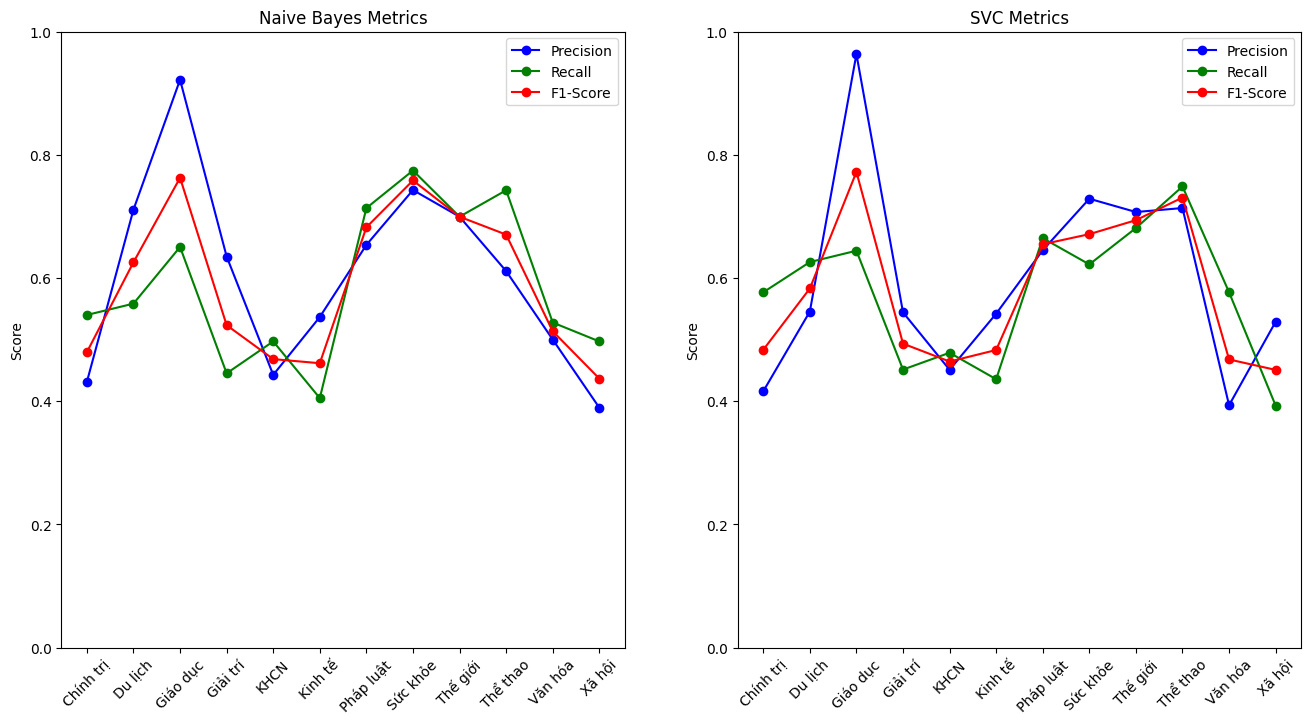

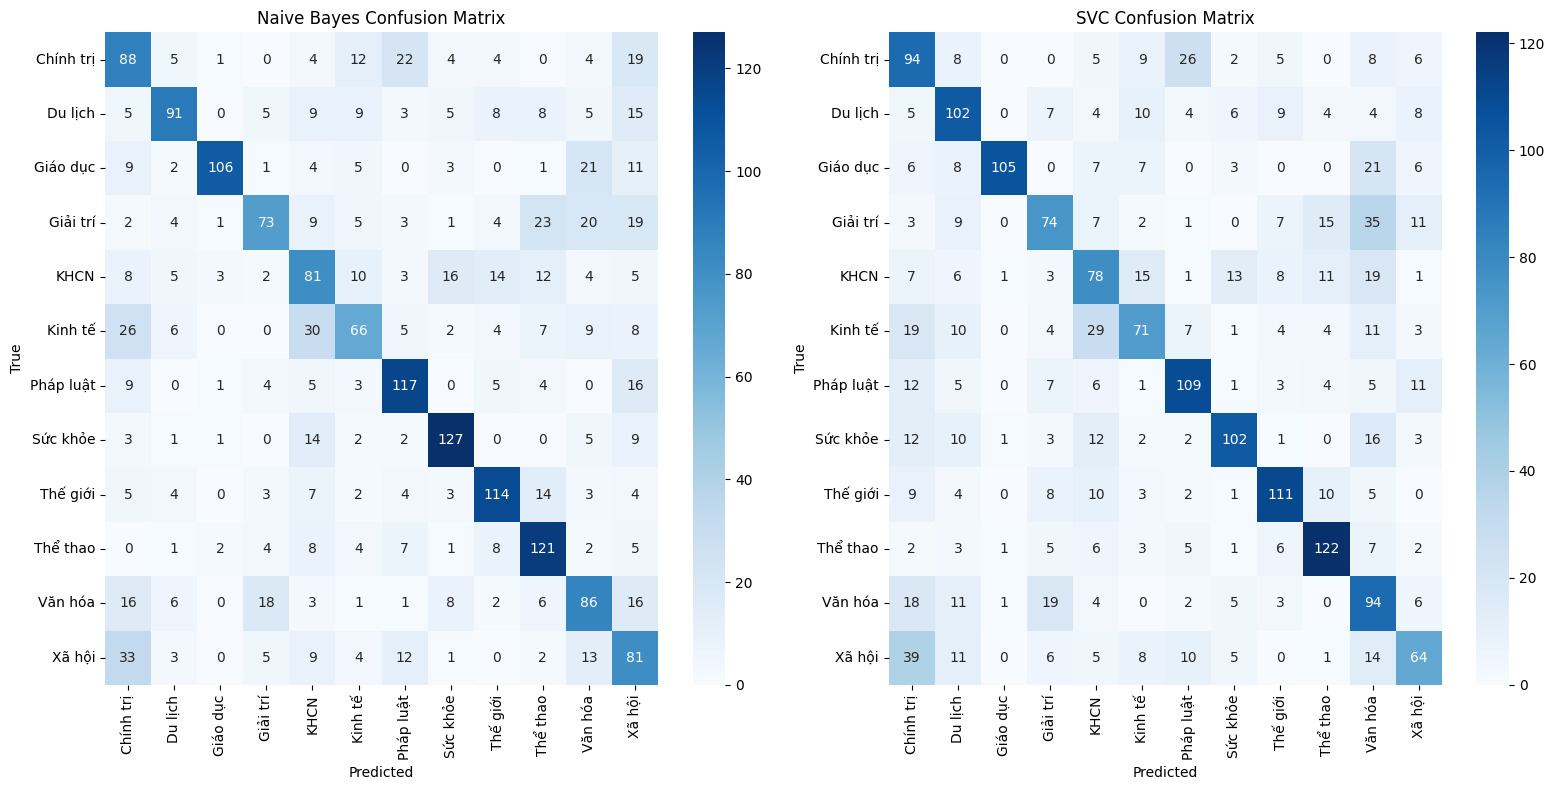

In [ ]:
# Tạo danh sách các báo cáo phân loại
reports = {
    'Naive Bayes': nb_report,
    'SVC': svm_report
}

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
fig_cm, axs_cm = plt.subplots(1, 2, figsize=(16, 8))

for i, (name, report) in enumerate(reports.items()):
    categories = list(report.keys())[:-3]  # exclude 'accuracy', 'macro avg', 'weighted avg'
    precisions = [report[cat]['precision'] for cat in categories]
    recalls = [report[cat]['recall'] for cat in categories]
    f1_scores = [report[cat]['f1-score'] for cat in categories]

    # In ra các thông số
    print(f'\n{name} Metrics:')
    for category in categories:
        print(f"{category}: Precision={report[category]['precision']:.2f}, Recall={report[category]['recall']:.2f}, F1-Score={report[category]['f1-score']:.2f}")

    # In ra độ chính xác trung bình
    accuracy = report['accuracy']
    print(f'Overall Accuracy: {accuracy:.2f}')

    # Vẽ biểu đồ đường
    axs[i].plot(categories, precisions, marker='o', label='Precision', color='blue')
    axs[i].plot(categories, recalls, marker='o', label='Recall', color='green')
    axs[i].plot(categories, f1_scores, marker='o', label='F1-Score', color='red')
    axs[i].set_ylim(0, 1)  # Đặt giới hạn trục y từ 0 đến 1
    axs[i].set_title(f'{name} Metrics')
    axs[i].set_ylabel('Score')
    axs[i].legend()
    axs[i].tick_params(axis='x', rotation=45)

    # Vẽ ma trận nhầm lẫn
    if name == 'Naive Bayes':
        cm = confusion_matrix(y_test, nb_y_pred, labels=le.classes_)
    elif name == 'SVC':
        cm = confusion_matrix(y_test, svm_y_pred, labels=le.classes_)

    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues', ax=axs_cm[i])
    axs_cm[i].set_title(f'{name} Confusion Matrix')
    axs_cm[i].set_xlabel('Predicted')
    axs_cm[i].set_ylabel('True')

plt.tight_layout()
plt.show()

In [ ]:
print("Nhãn dự đoán:" , le.inverse_transform(nb_model.predict(X_test_tfidf[:6])))
print("Nhãn thực tế: ", le.inverse_transform(y_train_enc[:6]))

Nhãn dự đoán: ['Văn hóa' 'Văn hóa' 'Thế giới' 'Kinh tế' 'Kinh tế' 'Sức khỏe']
Nhãn thực tế:  ['Thể thao' 'Pháp luật' 'Thể thao' 'Kinh tế' 'Kinh tế' 'Chính trị']


# Huấn luyện các mô hình học sâu

## Tạo dữ liệu huấn luyện và kiểm thử cho các mô hình học sâu

In [ ]:
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

In [ ]:
# Tải PhoBERT Large Tokenizer và Model
tokenizer = AutoTokenizer.from_pretrained('vinai/phobert-base')
embeder = AutoModel.from_pretrained('vinai/phobert-base')

# Chuyển mô hình sang GPU nếu có
embeder.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(64001, 768, padding_idx=1)
    (position_embeddings): Embedding(258, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

In [ ]:
def encode_texts(texts, tokenizer, embeder, max_length = 256):
  encoded_texts = []
  for text in tqdm(texts, desc = 'Convert word to vector'):
    inputs = tokenizer(text, return_tensors = 'pt', max_length = max_length, truncation = True, padding = "max_length").to(device)

    #Không tinh gradient vì không tính đạo hàm, chỉ thực hiện suy luận
    with torch.no_grad():
      outputs = embeder(**inputs)

    # Lấy vector mã hóa từ `last_hidden_state` và loại bỏ chiều batch.
    encoded_texts.append(outputs.last_hidden_state.squeeze(0))
    torch.cuda.empty_cache()
  return torch.stack(encoded_texts)

In [ ]:
test = ["Xin chào", "Đây là chương trình AI4E"]
encode_texts(test, tokenizer, embeder).shape

Convert word to vector:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([2, 256, 768])

In [ ]:
texts_train, texts_val, y_train_enc, y_val_enc = train_test_split(texts_train, y_train_enc, test_size = 0.1, random_state = 42)

In [ ]:
X_train_phobert = encode_texts(texts_train, tokenizer, embeder)
X_val_phobert = encode_texts(texts_val, tokenizer, embeder)
X_test_phobert = encode_texts(texts_test, tokenizer, embeder)

Convert word to vector:   0%|          | 0/7049 [00:00<?, ?it/s]

Convert word to vector:   0%|          | 0/784 [00:00<?, ?it/s]

Convert word to vector:   0%|          | 0/1959 [00:00<?, ?it/s]

In [ ]:
class TextDataset(Dataset):
  def __init__(self, texts, labels):
    self.texts = texts
    self.labels = labels
  def __len__(self):
    return len(self.texts)
  def __getitem__(self, idx):
    return self.texts[idx], self.labels[idx]
# Tạo Dataset cho tập huấn luyện và tập kiểm thử
train_dataset = TextDataset(X_train_phobert, y_train_enc)
val_dataset = TextDataset(X_val_phobert, y_val_enc)
test_dataset = TextDataset(X_test_phobert, y_test_enc)

# Tạo DataLoader cho tập huấn luyện và tập kiểm thử
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

## Định nghĩa các mô hình học sâu

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout=0.3, bidirectional=True):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2 if self.bidirectional else self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2 if self.bidirectional else self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

class CNNClassifier(nn.Module):
    def __init__(self, input_size, output_size, num_filters, kernel_sizes, max_length=256):
        super(CNNClassifier, self).__init__()
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=k) for k in kernel_sizes
        ])
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(num_filters * len(kernel_sizes), output_size)
        self.batch_norm = nn.BatchNorm1d(num_filters * len(kernel_sizes))

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Đổi chiều để phù hợp với Conv1d
        conv_outs = [F.relu(conv(x)) for conv in self.convs]  # Áp dụng Conv1d và ReLU
        pooled_outs = [self.pool(conv_out).squeeze(2) for conv_out in conv_outs]
        x = torch.cat(pooled_outs, dim=1)  # Nối các đầu ra từ các lớp Conv1d
        x = self.batch_norm(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
input_size = 768 # kich thước vector của PhoBert
hidden_size = 256
num_layers =  3
output_size = len(le.classes_)
num_filters = 100
kernel_size = [2,3,4,5]

In [ ]:
lstm_model = LSTMClassifier(input_size, hidden_size, output_size, num_layers).to(device)
cnn_model = CNNClassifier(input_size, output_size, num_filters, kernel_size, max_length=256).to(device)

In [ ]:
# Khởi tạo các mô hình
deep_models = {
    'LSTM': lstm_model,
    'CNN': cnn_model,
}

## Huấn luyện các mô hình học sâu

In [ ]:
# Hàm huấn luyện và đánh giá mô hình
def train_and_evaluate(model, train_loader, test_loader, num_epochs, criterion, optimizer_fn, scheduler_fn):
    # Khởi tạo optimizer
    optimizer = optimizer_fn(model.parameters())

    # Khởi tạo scheduler
    scheduler = scheduler_fn(optimizer)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, (texts, labels) in enumerate(train_loader):
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if((i+1) % 90 == 0):
                model.eval()
                val_losses = []
                with torch.no_grad():
                    for texts, labels in val_loader:
                        texts, labels = texts.to(device), labels.to(device)
                        outputs = model(texts)
                        loss = criterion(outputs, labels)
                        val_losses.append(loss.item())

                model.train()
                print("Epoch: [{}/{}], ".format(epoch + 1, num_epochs),
                  "Step: [{}/{}], ".format(i + 1, len(train_loader)),
                  "Loss: {:.4f}, ".format(running_loss / 100),
                  "Val Loss: {:.4f}".format(np.mean(val_losses)))
                running_loss = 0

        if scheduler is not None:
            scheduler.step()


    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

In [ ]:
# Khai báo criterion
criterion = nn.CrossEntropyLoss()

# Hàm tạo optimizer
def optimizer_fn(params):
    return torch.optim.Adam(params, lr = 0.001)

# Hàm tạo scheduler
def scheduler_fn(optimizer):
    return torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1)

# Số lượng epochs
num_epochs = 10

Training LSTM model...
Epoch: [1/10],  Step: [90/221],  Loss: 1.5079,  Val Loss: 0.9879
Epoch: [1/10],  Step: [180/221],  Loss: 0.9073,  Val Loss: 0.8303
Epoch: [2/10],  Step: [90/221],  Loss: 0.7016,  Val Loss: 0.8144
Epoch: [2/10],  Step: [180/221],  Loss: 0.6585,  Val Loss: 0.6956
Epoch: [3/10],  Step: [90/221],  Loss: 0.5775,  Val Loss: 0.6904
Epoch: [3/10],  Step: [180/221],  Loss: 0.5560,  Val Loss: 0.7129
Epoch: [4/10],  Step: [90/221],  Loss: 0.5005,  Val Loss: 0.7068
Epoch: [4/10],  Step: [180/221],  Loss: 0.5225,  Val Loss: 0.6588
Epoch: [5/10],  Step: [90/221],  Loss: 0.4184,  Val Loss: 0.6765
Epoch: [5/10],  Step: [180/221],  Loss: 0.4513,  Val Loss: 0.6785
Epoch: [6/10],  Step: [90/221],  Loss: 0.3158,  Val Loss: 0.6251
Epoch: [6/10],  Step: [180/221],  Loss: 0.2836,  Val Loss: 0.6190
Epoch: [7/10],  Step: [90/221],  Loss: 0.2323,  Val Loss: 0.6401
Epoch: [7/10],  Step: [180/221],  Loss: 0.2634,  Val Loss: 0.6482
Epoch: [8/10],  Step: [90/221],  Loss: 0.2253,  Val Loss: 0.

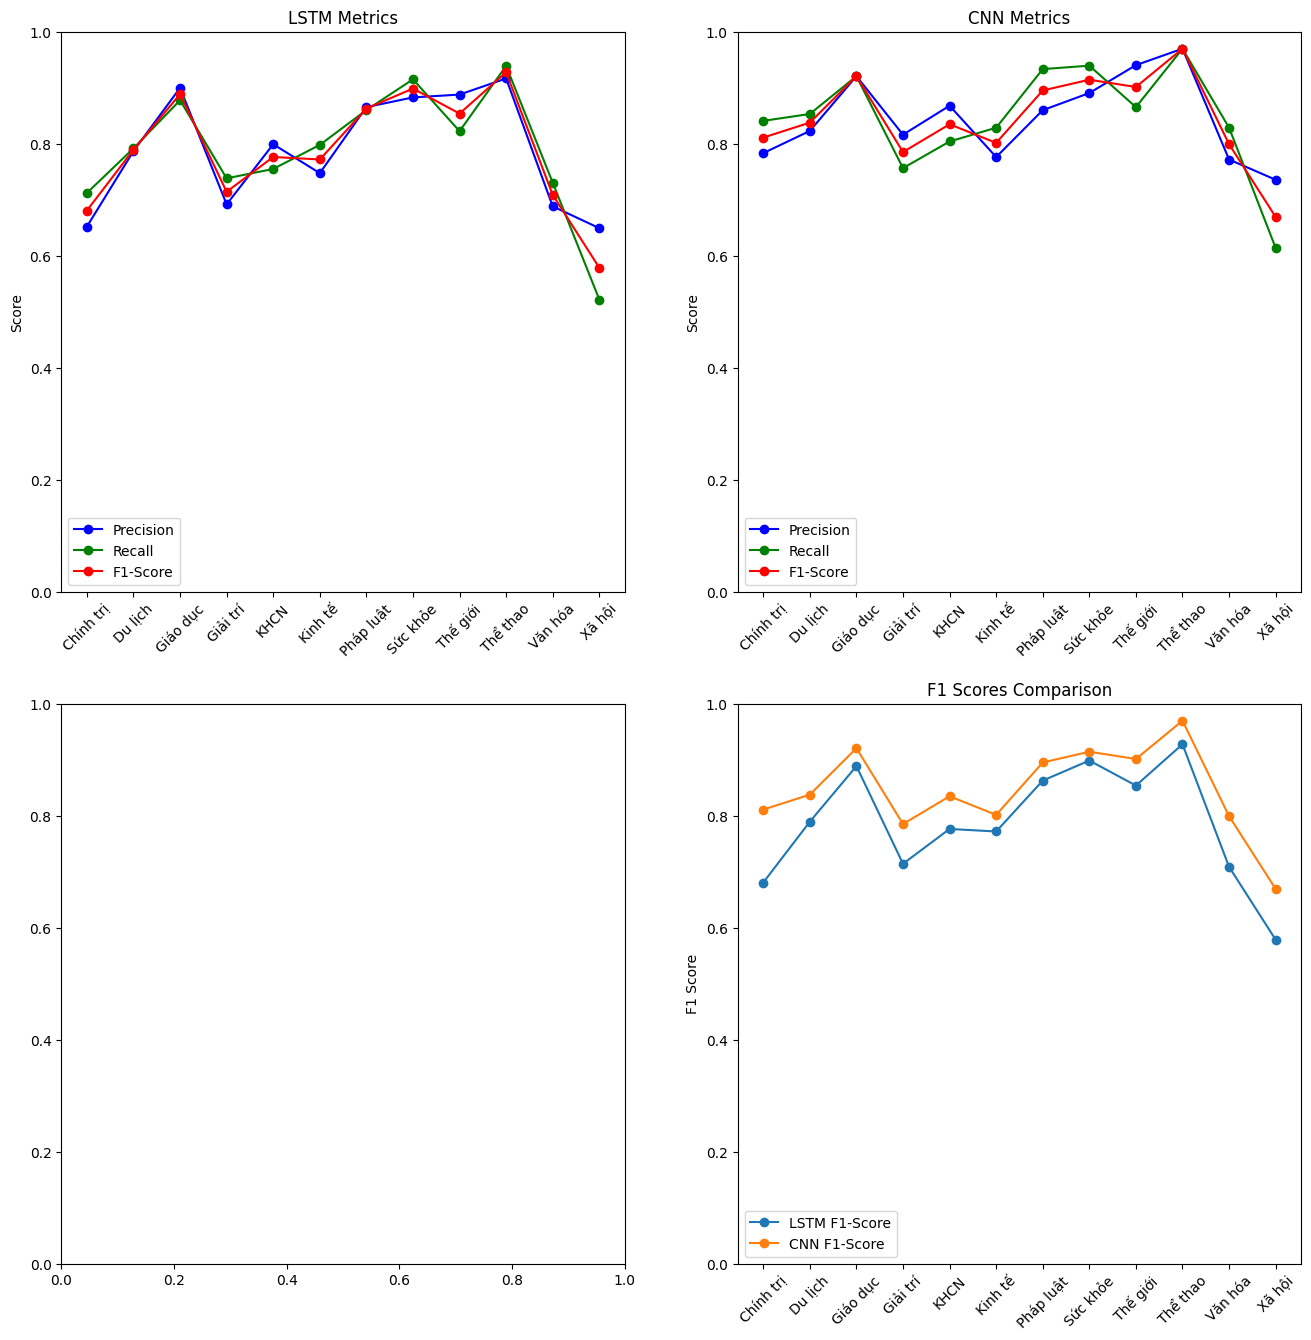

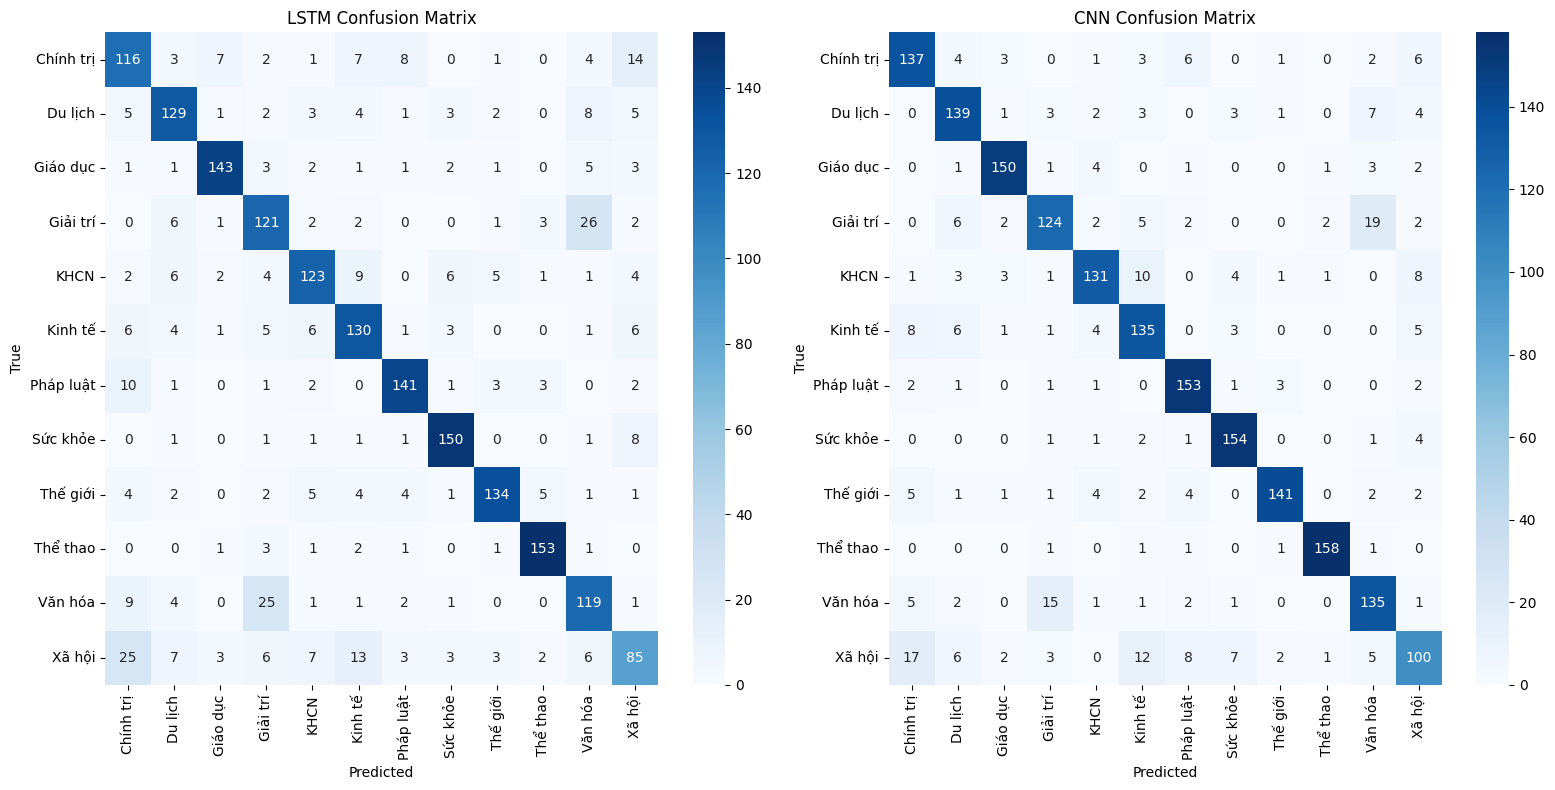

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
# Hình vẽ kết quả của mô hình sau khi train
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
fig_cm, axs_cm = plt.subplots(1, 2, figsize=(16, 8))

# Lưu trữ F1 scores của các mô hình
model_f1_scores = {}

for i, (name, model) in enumerate(deep_models.items()):
    print(f"Training {name} model...")
    y_test, y_pred = train_and_evaluate(model, train_loader, test_loader, num_epochs=num_epochs,
                                        criterion=criterion, optimizer_fn=optimizer_fn, scheduler_fn=scheduler_fn)
    y_test = le.inverse_transform(y_test)
    y_pred = le.inverse_transform(y_pred)

    # Tạo báo cáo phân loại
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    categories = list(report.keys())[:-3]  # exclude 'accuracy', 'macro avg', 'weighted avg'

    # Tạo dữ liệu để vẽ biểu đồ
    precisions = [report[cat]['precision'] for cat in categories]
    recalls = [report[cat]['recall'] for cat in categories]
    f1_scores = [report[cat]['f1-score'] for cat in categories]
    model_f1_scores[name] = f1_scores

    # In ra các thông số
    print(f'\n{name} Metrics:')
    for category in categories:
        print(f"{category}: Precision={report[category]['precision']:.2f}, Recall={report[category]['recall']:.2f}, F1-Score={report[category]['f1-score']:.2f}")

    # In ra độ chính xác trung bình
    accuracy = report['accuracy']
    print(f'Overall Accuracy: {accuracy:.2f}\n')

    # Vẽ biểu đồ đường
    axs[i // 2, i % 2].plot(categories, precisions, marker='o', label='Precision', color='blue')
    axs[i // 2, i % 2].plot(categories, recalls, marker='o', label='Recall', color='green')
    axs[i // 2, i % 2].plot(categories, f1_scores, marker='o', label='F1-Score', color='red')
    axs[i // 2, i % 2].set_ylim(0, 1)  # Đặt giới hạn trục y từ 0 đến 1
    axs[i // 2, i % 2].set_title(f'{name} Metrics')
    axs[i // 2, i % 2].set_ylabel('Score')
    axs[i // 2, i % 2].legend()
    axs[i // 2, i % 2].tick_params(axis='x', rotation=45)

    # Vẽ ma trận nhầm lẫn
    cm = confusion_matrix(y_test, y_pred, labels=le.classes_)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues', ax=axs_cm[i])
    axs_cm[i].set_title(f'{name} Confusion Matrix')
    axs_cm[i].set_xlabel('Predicted')
    axs_cm[i].set_ylabel('True')

# Vẽ F1 scores của cả 3 mô hình lên subplot thứ 4
for name, f1_scores in model_f1_scores.items():
    axs[1, 1].plot(categories, f1_scores, marker='o', label=f'{name} F1-Score')
axs[1, 1].set_ylim(0, 1)
axs[1, 1].set_title('F1 Scores Comparison')
axs[1, 1].set_ylabel('F1 Score')
axs[1, 1].legend()
axs[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Lấy một số batch dữ liệu từ test_loader
dataiter = iter(test_loader)

# Số batch bạn muốn lấy
num_batches = 2

for _ in range(num_batches):
    texts, labels = next(dataiter)

    # Chuyển dữ liệu sang thiết bị (GPU hoặc CPU)
    texts, labels = texts.to(device), labels.to(device)

    # Truyền dữ liệu qua mô hình
    outputs = lstm_model(texts)
    _, predicted = torch.max(outputs, 1)

    # In kết quả
    print('GroundTruth: ', ' '.join(f'{labels[j].item()}' for j in range(len(labels))))
    print('Predicted:   ', ' '.join(f'{predicted[j].item()}' for j in range(len(predicted))))
    print('-' * 100)  # Để phân cách giữa các batch

GroundTruth:  11 10 8 5 3 8 3 6 11 1 10 0 8 3 11 1 5 7 8 0 10 8 3 10 0 9 7 0 2 2 11 5
Predicted:    11 10 8 5 3 8 10 6 0 1 10 0 8 3 11 1 4 7 6 0 1 8 3 3 2 9 7 8 2 2 11 1
----------------------------------------------------------------------------------------------------
GroundTruth:  11 7 0 2 4 9 7 7 2 8 11 4 8 2 2 6 5 1 9 8 0 1 1 8 5 6 2 5 5 9 0 9
Predicted:    5 7 0 2 4 9 11 7 2 8 11 4 8 2 2 6 5 1 9 0 0 1 1 0 5 6 4 10 5 9 10 9
----------------------------------------------------------------------------------------------------


In [ ]:
# Lấy một số batch dữ liệu từ test_loader
dataiter = iter(test_loader)

# Số batch bạn muốn lấy
num_batches = 3

for _ in range(num_batches):
    texts, labels = next(dataiter)

    # Chuyển dữ liệu sang thiết bị (GPU hoặc CPU)
    texts, labels = texts.to(device), labels.to(device)

    # Truyền dữ liệu qua mô hình
    outputs = cnn_model(texts)
    _, predicted = torch.max(outputs, 1)

    # In kết quả
    print('GroundTruth: ', ' '.join(f'{labels[j].item()}' for j in range(len(labels))))
    print('Predicted:   ', ' '.join(f'{predicted[j].item()}' for j in range(len(predicted))))
    print('-' * 100)  # Để phân cách giữa các batch

GroundTruth:  11 10 8 5 3 8 3 6 11 1 10 0 8 3 11 1 5 7 8 0 10 8 3 10 0 9 7 0 2 2 11 5
Predicted:    1 10 8 5 3 8 10 6 11 1 10 0 8 3 11 1 4 7 11 0 10 8 3 10 2 9 7 0 2 2 11 1
----------------------------------------------------------------------------------------------------
GroundTruth:  11 7 0 2 4 9 7 7 2 8 11 4 8 2 2 6 5 1 9 8 0 1 1 8 5 6 2 5 5 9 0 9
Predicted:    5 7 0 2 4 9 11 7 2 8 3 4 8 2 2 6 5 1 9 0 0 1 1 0 5 6 4 5 5 9 10 9
----------------------------------------------------------------------------------------------------
GroundTruth:  11 9 0 10 9 8 1 10 3 5 8 9 1 9 6 0 9 2 2 11 10 7 9 1 8 3 9 5 2 10 7 11
Predicted:    11 9 11 10 9 8 1 0 4 5 8 9 5 9 6 0 9 2 2 11 10 7 9 1 8 10 9 0 2 10 7 2
----------------------------------------------------------------------------------------------------
